<h3>Kaggle Challenge</h3>
<h1>Expedia Hotel Recommendations</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

### Imports

In [1]:
print("Imports")
import numpy as np
import pandas as pd
from datetime import timedelta as td
pd.set_option('display.max_columns', 500)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

ROWS = 200000

Imports


In [2]:
expediaDF = pd.read_csv('data/train.csv.gz', compression='gzip',
                   error_bad_lines=False)

In [2]:
destinationDF = pd.read_csv('data/destinations.csv.gz', compression='gzip',
                   error_bad_lines=False)

In [3]:
expediaDF.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,21


In [5]:
destinationDF.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,-2.209855,-2.224164,-2.110723,-2.186008,-2.224164,-2.124474,-2.224164,-2.156467,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.153316,-2.186008,-2.224164,-2.224164,-2.224164,-2.128237,-2.158309,

## Data Analysis

- How many data?

In [7]:
print('Rows: ',expediaDF['site_name'].size)

Rows:  37670293


### Types of the features

Text(0.5,1,'Features Quantity per Type')

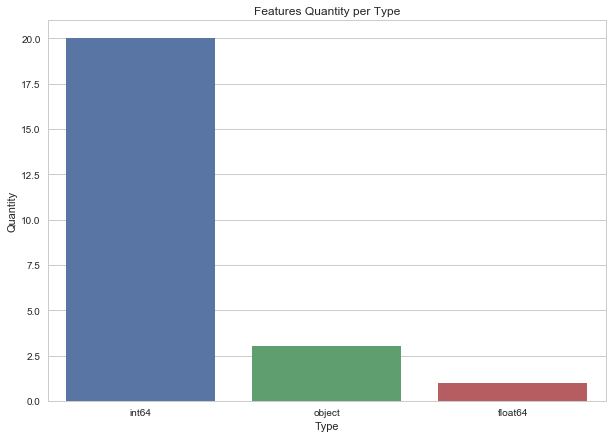

In [28]:
fig, ax = plt.subplots()

types = expediaDF.dtypes.value_counts()

sns.barplot(types.index, types.values)
ax.set_ylabel("Quantity")
ax.set_xlabel("Type")
ax.set_title('Features Quantity per Type')

### Hotel Clusters

In [39]:
uniqueClusters = expediaDF['hotel_cluster'].unique().size
print("Total n. hotel clusters: ", uniqueClusters)

Total n. hotel clusters:  100


Distribution of the Hotel Clusters


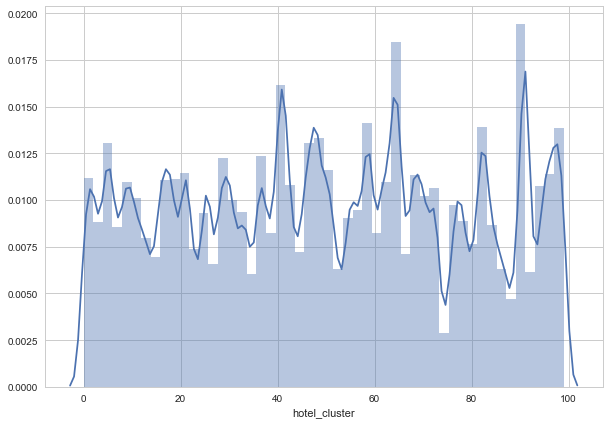

In [40]:
print("Distribution of the Hotel Clusters")
sns.distplot(expediaDF['hotel_cluster']);

### Users

In [48]:
uniqueUsers = expediaDF['user_id'].unique().size
print("Total n. usuários: ", uniqueUsers)

Total n. usuários:  1198786


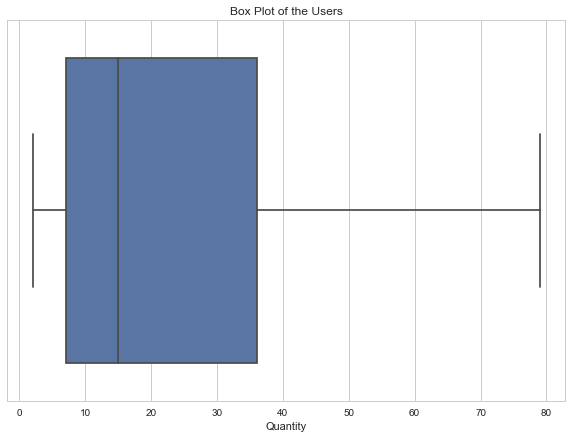

In [47]:
plt.figure(figsize=(10,7))
sns.boxplot(expediaDF['user_id'].value_counts(),showfliers=False)
plt.title('Box Plot of the Users')
plt.xlabel('Quantity')
plt.show()

### Destination

In [50]:
unique = expediaDF['srch_destination_id'].unique().size
print("Total n. destinations: ", unique)

Total n. usuários:  59455


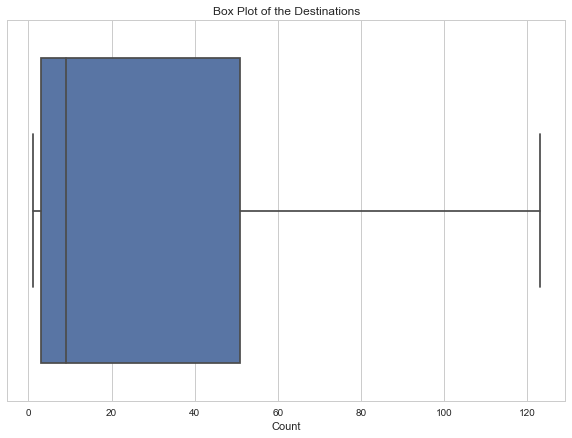

In [56]:
plt.figure(figsize=(10,7))
sns.boxplot(expediaDF['srch_destination_id'].value_counts(),showfliers=False)
plt.title('Box Plot of the Destinations')
plt.xlabel('Count')
plt.show()

In [10]:
destinationDF['srch_destination_id'].size

62106

### Type of Destination

In [61]:
unique = expediaDF['srch_destination_type_id'].unique().size
print("Total n. type of destinations: ", unique)

Total n. type of destinations:  10


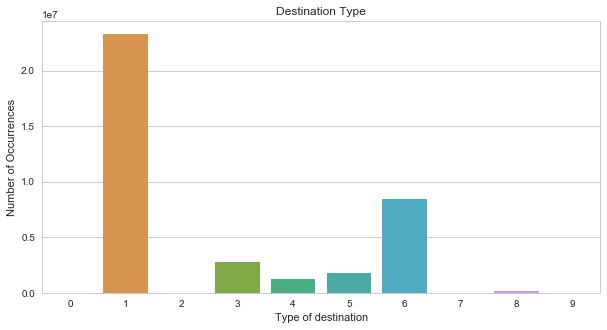

In [69]:
destTypeCount  = expediaDF['srch_destination_type_id'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(destTypeCount.index, destTypeCount.values)
plt.title('Destination Type')
plt.ylabel('Number of Occurrences')
plt.xlabel('Type of destination')
plt.show()

### Booking vs Click

Click      34669600
Booking     3000693
Name: is_booking, dtype: int64


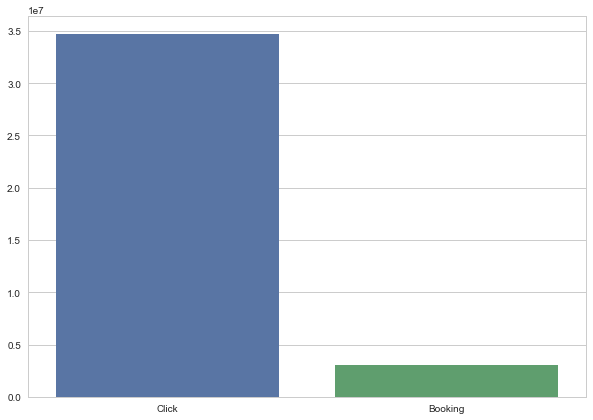

In [81]:
#1 is booking, 0 click
bookingCount = expediaDF.is_booking.value_counts()
bookingCount.index = ["Click",  "Booking"]
sns.barplot(bookingCount.index, bookingCount.values)

ax.set_ylabel("Quantity")
ax.set_xlabel("Type")
ax.set_title('Features Quantity per Type')
print(bookingCount)

### Missing Values

**Missing values** 
orig_destination_distance    13525001
srch_co                         47084
srch_ci                         47083
dtype: int64


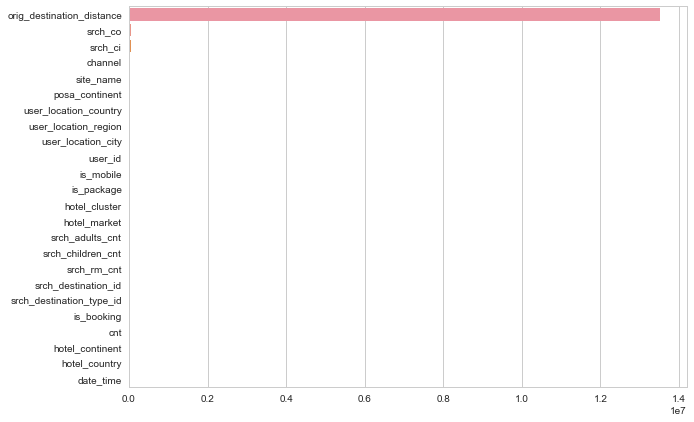

In [108]:
missingValues = expediaDF.isnull().sum().sort_values(ascending=False)
print('**Missing values** ')
print(missingValues[missingValues > 0])
sns.barplot(missingValues.values, missingValues.index)

### Checkin / Checkout

In [6]:
checkInOut = expediaDF.dropna(subset = ['srch_ci', 'srch_co'])

In [7]:
size = checkInOut[checkInOut['srch_co'] < checkInOut['srch_ci']].size
print("Checkin after  Checkout: ", size)

Checkin after  Checkout:  19152


In [8]:
checkInOut = checkInOut[checkInOut['srch_co'] > checkInOut['srch_ci']] #normalization
checkInOut['srch_ci'] = checkInOut['srch_ci'].astype('datetime64[ns]')
checkInOut['srch_co'] = checkInOut['srch_co'].astype('datetime64[ns]')
diff = checkInOut['srch_co'] - checkInOut['srch_ci']

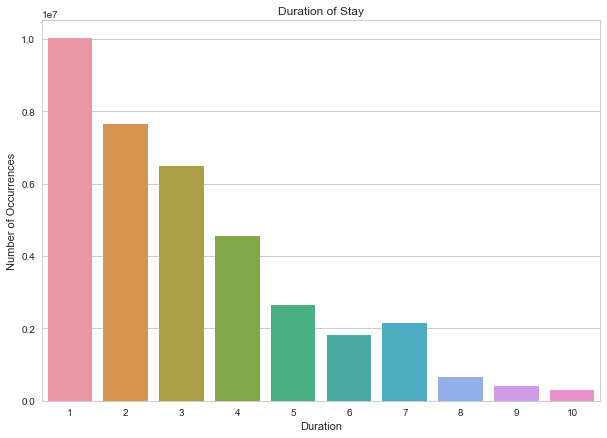

In [52]:
diffCount = diff.value_counts()
diffCount.index = (diffCount.index / np.timedelta64(1, 'D')).astype(int)
diffCount = diffCount.sort_values(ascending=False)
top10 = diffCount[:10]

sns.barplot(top10.index, top10.values)
plt.title('Duration of Stay')
plt.ylabel('Number of Occurrences')
plt.xlabel('Duration')
plt.show()


In [ ]:
del checkInOut
del diff
del diffCount

### Search numbers

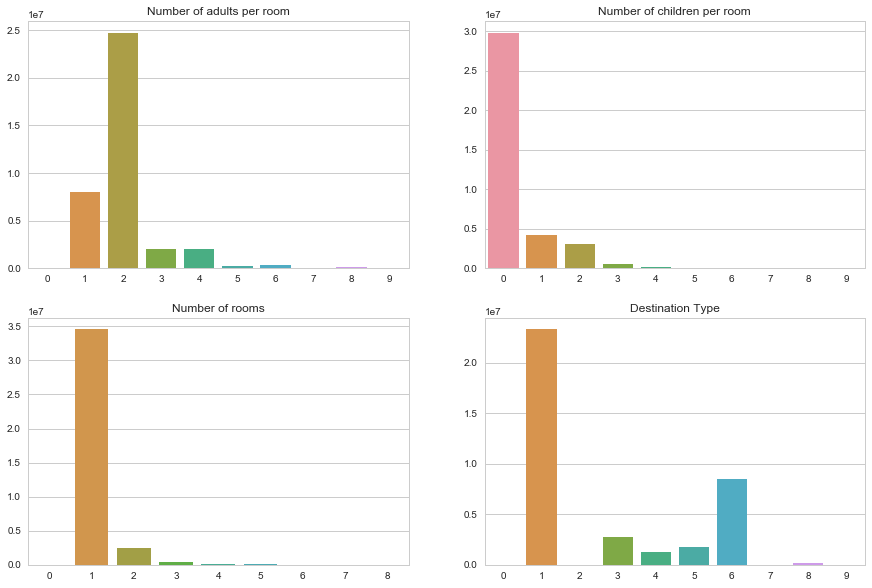

In [16]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))

adultsCnt = expediaDF.srch_adults_cnt.value_counts()
sns.barplot(adultsCnt.index, adultsCnt.values, ax=ax1)
# sns.countplot(adultsCnt, ax=ax1)
ax1.set_title('Number of adults per room')

childrenCnt = expediaDF.srch_children_cnt.value_counts()
sns.barplot(childrenCnt.index, childrenCnt.values, ax=ax2)
ax2.set_title('Number of children per room')

roomCnt = expediaDF.srch_rm_cnt.value_counts()
sns.barplot(roomCnt.index, roomCnt.values, ax=ax3)
ax3.set_title('Number of rooms')

destTypeCnt = expediaDF.srch_destination_type_id.value_counts()
sns.barplot(destTypeCnt.index, destTypeCnt.values, ax=ax4)
ax4.set_title('Destination Type')

plt.show()

### Correlation Map

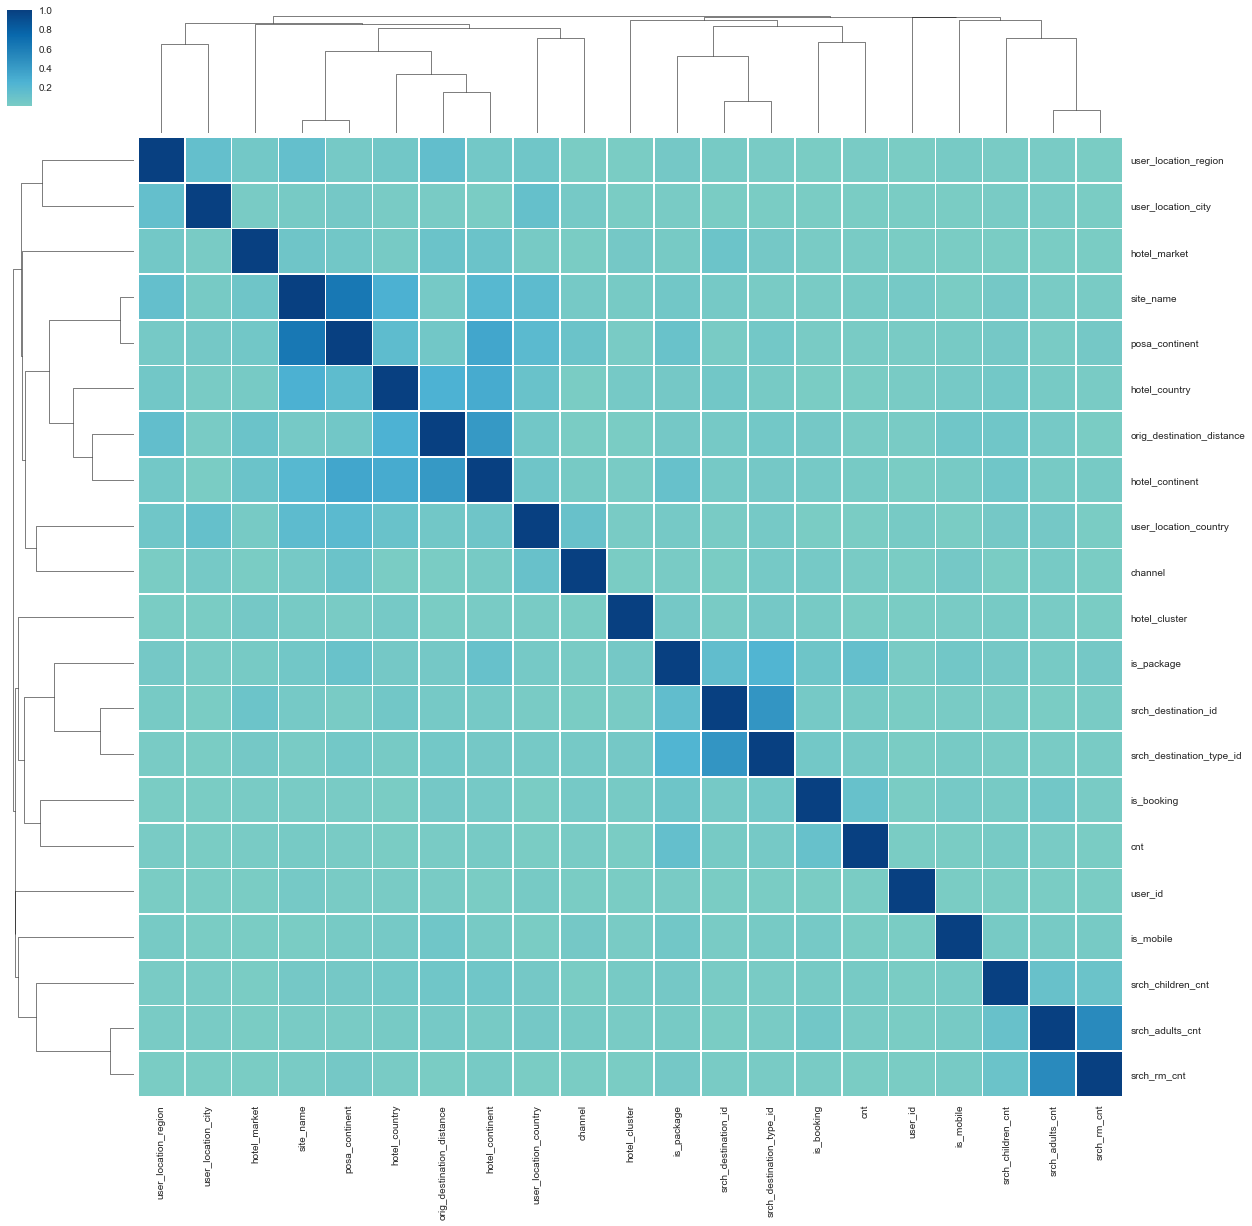

In [34]:
CorrelationMat=expediaDF.corr().abs()
sns.clustermap(CorrelationMat, center=0, cmap="GnBu",
               linewidths=.75, figsize=(10, 10), metric="correlation")
plt.show()

## Features correlated to Hotel Cluster

In [ ]:
sns.FacetGrid(expediaDF, row="hotel_cluster", col="srch_destination_id", margin_titles=True)
# bins = np.linspace(0, 60, 13)
# g.map(plt.hist, "total_bill", color="steelblue", bins=bins)